# Analysis of `Human` Evaluator Results RQ2

# Imports and load data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Load the validation results
df = pd.read_csv('v3 Round 01_Validation_Master_File_Human_2_CLEAN.csv')
df.head(3)

Question_id                    Domain  \
0  0d3c97d7-598f-4aef-9adc-f6d440f80766  math_used_in_supermarket   
1  7554a756-434d-4289-a237-c1adb52f1039  math_used_in_supermarket   
2  ab48c505-6e01-4f56-b3ce-d25993cb044c  math_used_in_supermarket   

  question_format                                      question_text  \
0             mcq  Which of the following best describes the unit...   
1             mcq  A supermarket offers a bulk discount where if ...   
2             mcq  Which of the following pricing strategies uses...   

                                         mcq_options  \
0   A. $0.50 per litre\n B. $0.75 per litre\n C. ...   
1  A. Each juice pack effectively costs $4 in the...   
2   A. Cost-plus pricing\n B. Penetration pricing...   

                                   mcq_right_answers true_false_correct_value  \
0  B.\nThis is correct because it accurately refl...                      NaN   
1  A.\nThis option correctly deconstructs the sce...                      NaN   
2  C.\nCorrect! Psychological pricing uses number...                      NaN   

  true_false_correct_ans_explanation true_false_incorrect_ans_explanation  \
0                                NaN                                  NaN   
1                                NaN                                  NaN   
2                                NaN                                  NaN   

  short_answer_expected_answer  ... categorisation_human_0005  \
0                          NaN  ...        minimal complexity   
1                          NaN  ...                  moderate   
2                          NaN  ...          very challenging   

   categorisation_human_0006 categorisation_human_0007 ranking_human_0001  \
0            zero complexity                       NaN                NaN   
1             low complexity                       NaN                NaN   
2                challenging                       NaN                NaN   

  ranking_human_0002 ranking_human_0003  ranking_human_0004  \
0                  2                  1                   1   
1                  4                  4                   1   
2                  3                  5                   2   

  ranking_human_0005 ranking_human_0006 ranking_human_0007  
0                  1                1.0                NaN  
1                  3                3.0                NaN  
2                  6                4.0                NaN  

[3 rows x 31 columns]

# 1.0 Basic Data Cleaning

In [2]:
# clean transform column names
old_cols = df.columns
new_cols = [col.replace('/', '_').replace(' ', '_').lower().strip() for col in old_cols]
df.columns = new_cols
df.columns

Index(['question_id', 'domain', 'question_format', 'question_text',
       'mcq_options', 'mcq_right_answers', 'true_false_correct_value',
       'true_false_correct_ans_explanation',
       'true_false_incorrect_ans_explanation', 'short_answer_expected_answer',
       'short_answer_expected_ans_explanation', 'ci_score',
       'ci_complexity_category', 'llm_used_for_question_gen',
       'llm_difficulty_requested', 'pdf_filename', 'pdf_question_number',
       'categorisation_human_0001', 'categorisation_human_0002',
       'categorisation_human_0003', 'categorisation_human_0004',
       'categorisation_human_0005', 'categorisation_human_0006',
       'categorisation_human_0007', 'ranking_human_0001', 'ranking_human_0002',
       'ranking_human_0003', 'ranking_human_0004', 'ranking_human_0005',
       'ranking_human_0006', 'ranking_human_0007'],
      dtype='object')

# 2.0 Define Common Vars

In [3]:
# Define category mapping for analysis
category_mapping = {
    'zero_complexity': 0,
    'minimal_complexity': 1,
    'low_complexity': 2,
    'moderate': 3,
    'challenging': 4,
    'very_challenging': 5,
}

# Calculate agreement by CI complexity category
category_names = list(category_mapping.keys())
category_names

['zero_complexity',
 'minimal_complexity',
 'low_complexity',
 'moderate',
 'challenging',
 'very_challenging']

### 2.2 Complexity Category Variables: Clean, Transform and map

In [4]:
judges_cat_stem = 'categorisation_human_'
judge_category_assignment_cols = [col for col in df.columns if judges_cat_stem in col]
judges = [col.split('_')[-1] for col in df.columns if judges_cat_stem in col]

# clean and transform ci category labels
df['ci_complexity_category'] = df['ci_complexity_category'].str.replace(' ', '_').str.lower().str.strip()

# clean and transform judge category labels
for col in judge_category_assignment_cols:
    df[col] = df[col].str.replace(' ', '_').str.lower().str.strip()

# Map "CI complexity" categories to Numerical Values
df['ci_category_num'] = df['ci_complexity_category'].str.lower().str.strip().map(category_mapping)

# Map "judge-assigned" categories to Numerical Values
for col in judge_category_assignment_cols:
    df[col + '_num'] = df[col].map(category_mapping)

print(judge_category_assignment_cols)
print()
print(judges)
print()
print(df.columns)

['categorisation_human_0001', 'categorisation_human_0002', 'categorisation_human_0003', 'categorisation_human_0004', 'categorisation_human_0005', 'categorisation_human_0006', 'categorisation_human_0007']

['0001', '0002', '0003', '0004', '0005', '0006', '0007']

Index(['question_id', 'domain', 'question_format', 'question_text',
       'mcq_options', 'mcq_right_answers', 'true_false_correct_value',
       'true_false_correct_ans_explanation',
       'true_false_incorrect_ans_explanation', 'short_answer_expected_answer',
       'short_answer_expected_ans_explanation', 'ci_score',
       'ci_complexity_category', 'llm_used_for_question_gen',
       'llm_difficulty_requested', 'pdf_filename', 'pdf_question_number',
       'categorisation_human_0001', 'categorisation_human_0002',
       'categorisation_human_0003', 'categorisation_human_0004',
       'categorisation_human_0005', 'categorisation_human_0006',
       'categorisation_human_0007', 'ranking_human_0001', 'ranking_human_0002',
   

# 4.0 RQ2 Analysis: Alignment between CI Complexity Categories and Human Assigned Categories
- The CI Score for each question is mapped to a Complexity Category comprising of "Zero Complexity", "Minimal Complexity", "Low Complexity", "Moderate", "Challenging" and "Very Challenging". This is not visible to judges.
- Judges are asked to assign a complexity category to each question.

In [5]:
# import pandas as pd
# import numpy as np
# import krippendorff

# # Load the data
# df = pd.read_csv('z_human_evaluation.csv')

# # Define human judge columns
# human_judges = [f'categorisation_human_{i:04d}_num' for i in range(1, 8)]

# # Function to calculate Krippendorff's alpha
# def calculate_krippendorff_alpha(data):
#     # Convert to list of lists, handling missing values
#     ratings = data[human_judges].values.T.tolist()
#     # Remove positions where all judges are NaN
#     valid_ratings = []
#     for i in range(len(ratings[0])):
#         column = [ratings[j][i] for j in range(len(ratings))]
#         if not all(pd.isna(x) for x in column):
#             valid_ratings.append(column)
#     # Calculate alpha if we have enough data
#     if len(valid_ratings) > 1:
#         return krippendorff.alpha(reliability_data=valid_ratings, level_of_measurement='ordinal')
#     return np.nan

# # Calculate overall agreement
# overall_alpha = calculate_krippendorff_alpha(df)
# print(f"Overall Krippendorff's alpha: {overall_alpha:.3f}")

# # Agreement by domain
# for domain in df['domain'].unique():
#     domain_data = df[df['domain'] == domain]
#     alpha = calculate_krippendorff_alpha(domain_data)
#     print(f"Domain '{domain}' alpha: {alpha:.3f}")

# # Agreement by question format
# for fmt in df['question_format'].unique():
#     fmt_data = df[df['question_format'] == fmt]
#     alpha = calculate_krippendorff_alpha(fmt_data)
#     print(f"Format '{fmt}' alpha: {alpha:.3f}")

# # Agreement by domain-format combination
# for domain in df['domain'].unique():
#     for fmt in df['question_format'].unique():
#         combo_data = df[(df['domain'] == domain) & (df['question_format'] == fmt)]
#         if len(combo_data) > 0:
#             alpha = calculate_krippendorff_alpha(combo_data)
#             print(f"Domain '{domain}' + Format '{fmt}' alpha: {alpha:.3f}")

C:\Users\richa\AppData\Local\Temp\ipykernel_6220\592358280.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_data['Category'] = domain_data['Category'].str.replace('Domain: ', '')
C:\Users\richa\AppData\Local\Temp\ipykernel_6220\592358280.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  format_data['Category'] = format_data['Category'].str.replace('Format: ', '')
C:\Users\richa\AppData\Local\Temp\ipykernel_6220\592358280.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy o

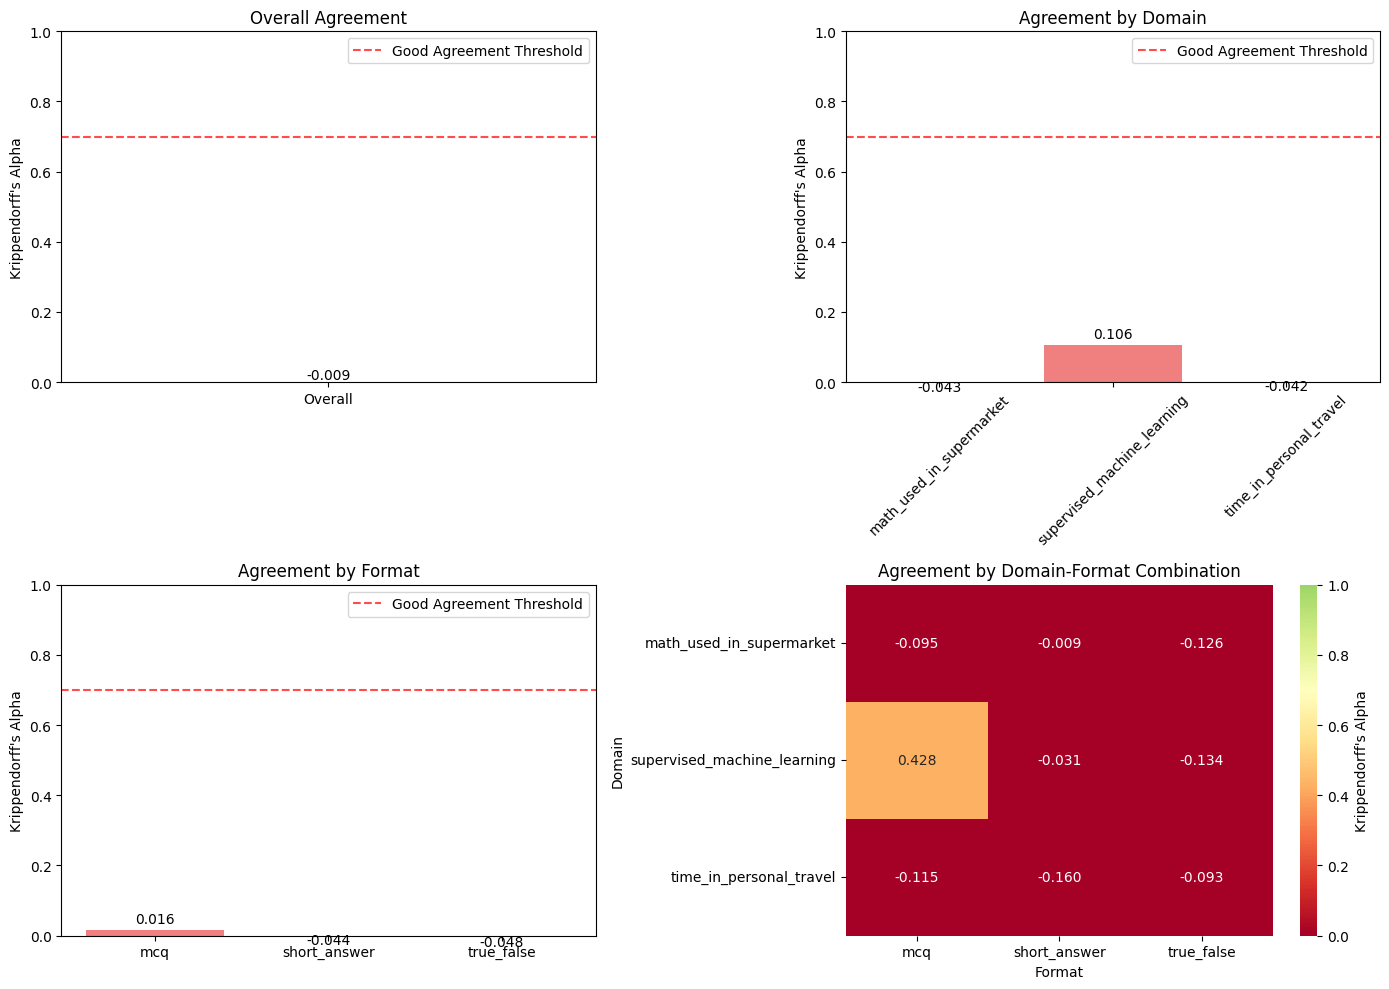

Summary of Krippendorff's Alpha Values:
Overall                                 : -0.009 (Poor agreement)
Domain: math_used_in_supermarket        : -0.043 (Poor agreement)
Domain: supervised_machine_learning     : 0.106 (Poor agreement)
Domain: time_in_personal_travel         : -0.042 (Poor agreement)
Format: mcq                             : 0.016 (Poor agreement)
Format: short_answer                    : -0.044 (Poor agreement)
Format: true_false                      : -0.048 (Poor agreement)
math_used_in_supermarket - mcq          : -0.095 (Poor agreement)
math_used_in_supermarket - short_answer : -0.009 (Poor agreement)
math_used_in_supermarket - true_false   : -0.126 (Poor agreement)
supervised_machine_learning - mcq       : 0.428 (Moderate agreement)
supervised_machine_learning - short_answer: -0.031 (Poor agreement)
supervised_machine_learning - true_false: -0.134 (Poor agreement)
time_in_personal_travel - mcq           : -0.115 (Poor agreement)
time_in_personal_travel - short_a

In [6]:
import pandas as pd
import numpy as np
import krippendorff
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load the data
df = pd.read_csv('z_human_evaluation.csv')

# Define human judge columns
human_judges = [f'categorisation_human_{i:04d}_num' for i in range(1, 8)]

# Function to calculate Krippendorff's alpha
def calculate_krippendorff_alpha(data):
    # Convert to list of lists, handling missing values
    ratings = data[human_judges].values.T.tolist()
    # Remove positions where all judges are NaN
    valid_ratings = []
    for i in range(len(ratings[0])):
        column = [ratings[j][i] for j in range(len(ratings))]
        if not all(pd.isna(x) for x in column):
            valid_ratings.append(column)
    # Calculate alpha if we have enough data
    if len(valid_ratings) > 1:
        return krippendorff.alpha(reliability_data=valid_ratings, level_of_measurement='ordinal')
    return np.nan

# Calculate agreement values
results = {}

# Overall agreement
results['Overall'] = calculate_krippendorff_alpha(df)

# Agreement by domain
for domain in df['domain'].unique():
    domain_data = df[df['domain'] == domain]
    results[f'Domain: {domain}'] = calculate_krippendorff_alpha(domain_data)

# Agreement by format
for fmt in df['question_format'].unique():
    fmt_data = df[df['question_format'] == fmt]
    results[f'Format: {fmt}'] = calculate_krippendorff_alpha(fmt_data)

# Agreement by domain-format combination
for domain in df['domain'].unique():
    for fmt in df['question_format'].unique():
        combo_data = df[(df['domain'] == domain) & (df['question_format'] == fmt)]
        if len(combo_data) > 0:
            results[f'{domain} - {fmt}'] = calculate_krippendorff_alpha(combo_data)

# Create a DataFrame for visualization
viz_df = pd.DataFrame(list(results.items()), columns=['Category', 'Alpha'])
viz_df['Type'] = viz_df['Category'].apply(
    lambda x: 'Overall' if x == 'Overall' 
    else 'Domain' if x.startswith('Domain:') 
    else 'Format' if x.startswith('Format:') 
    else 'Combination'
)

# Set up the plot
plt.figure(figsize=(14, 10))

# Create subplots
# 1. Overall agreement
plt.subplot(2, 2, 1)
overall_data = viz_df[viz_df['Type'] == 'Overall']
colors = ['lightblue' if x >= 0.7 else 'lightcoral' for x in overall_data['Alpha']]
bars = plt.bar(overall_data['Category'], overall_data['Alpha'], color=colors)
plt.title('Overall Agreement')
plt.ylabel("Krippendorff's Alpha")
plt.ylim(0, 1)
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Good Agreement Threshold')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')
plt.legend()

# 2. Agreement by domain
plt.subplot(2, 2, 2)
domain_data = viz_df[viz_df['Type'] == 'Domain']
domain_data['Category'] = domain_data['Category'].str.replace('Domain: ', '')
colors = ['lightblue' if x >= 0.7 else 'lightcoral' for x in domain_data['Alpha']]
bars = plt.bar(domain_data['Category'], domain_data['Alpha'], color=colors)
plt.title('Agreement by Domain')
plt.ylabel("Krippendorff's Alpha")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Good Agreement Threshold')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')
plt.legend()

# 3. Agreement by format
plt.subplot(2, 2, 3)
format_data = viz_df[viz_df['Type'] == 'Format']
format_data['Category'] = format_data['Category'].str.replace('Format: ', '')
colors = ['lightblue' if x >= 0.7 else 'lightcoral' for x in format_data['Alpha']]
bars = plt.bar(format_data['Category'], format_data['Alpha'], color=colors)
plt.title('Agreement by Format')
plt.ylabel("Krippendorff's Alpha")
plt.ylim(0, 1)
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Good Agreement Threshold')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')
plt.legend()

# 4. Agreement by domain-format combination (heatmap)
plt.subplot(2, 2, 4)
combo_data = viz_df[viz_df['Type'] == 'Combination']
# Extract domain and format from the category string
combo_data[['Domain', 'Format']] = combo_data['Category'].str.split(' - ', expand=True)
# Create a pivot table for the heatmap
heatmap_data = combo_data.pivot(index='Domain', columns='Format', values='Alpha')

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0.7, vmin=0, vmax=1, cbar_kws={'label': "Krippendorff's Alpha"})
plt.title('Agreement by Domain-Format Combination')
plt.tight_layout()

plt.show()

# Print a summary table
print("Summary of Krippendorff's Alpha Values:")
print("="*50)
for category, alpha in results.items():
    interpretation = "Good agreement" if alpha >= 0.7 else "Moderate agreement" if alpha >= 0.4 else "Poor agreement"
    print(f"{category:40}: {alpha:.3f} ({interpretation})")

# Agreement between Human and CI 

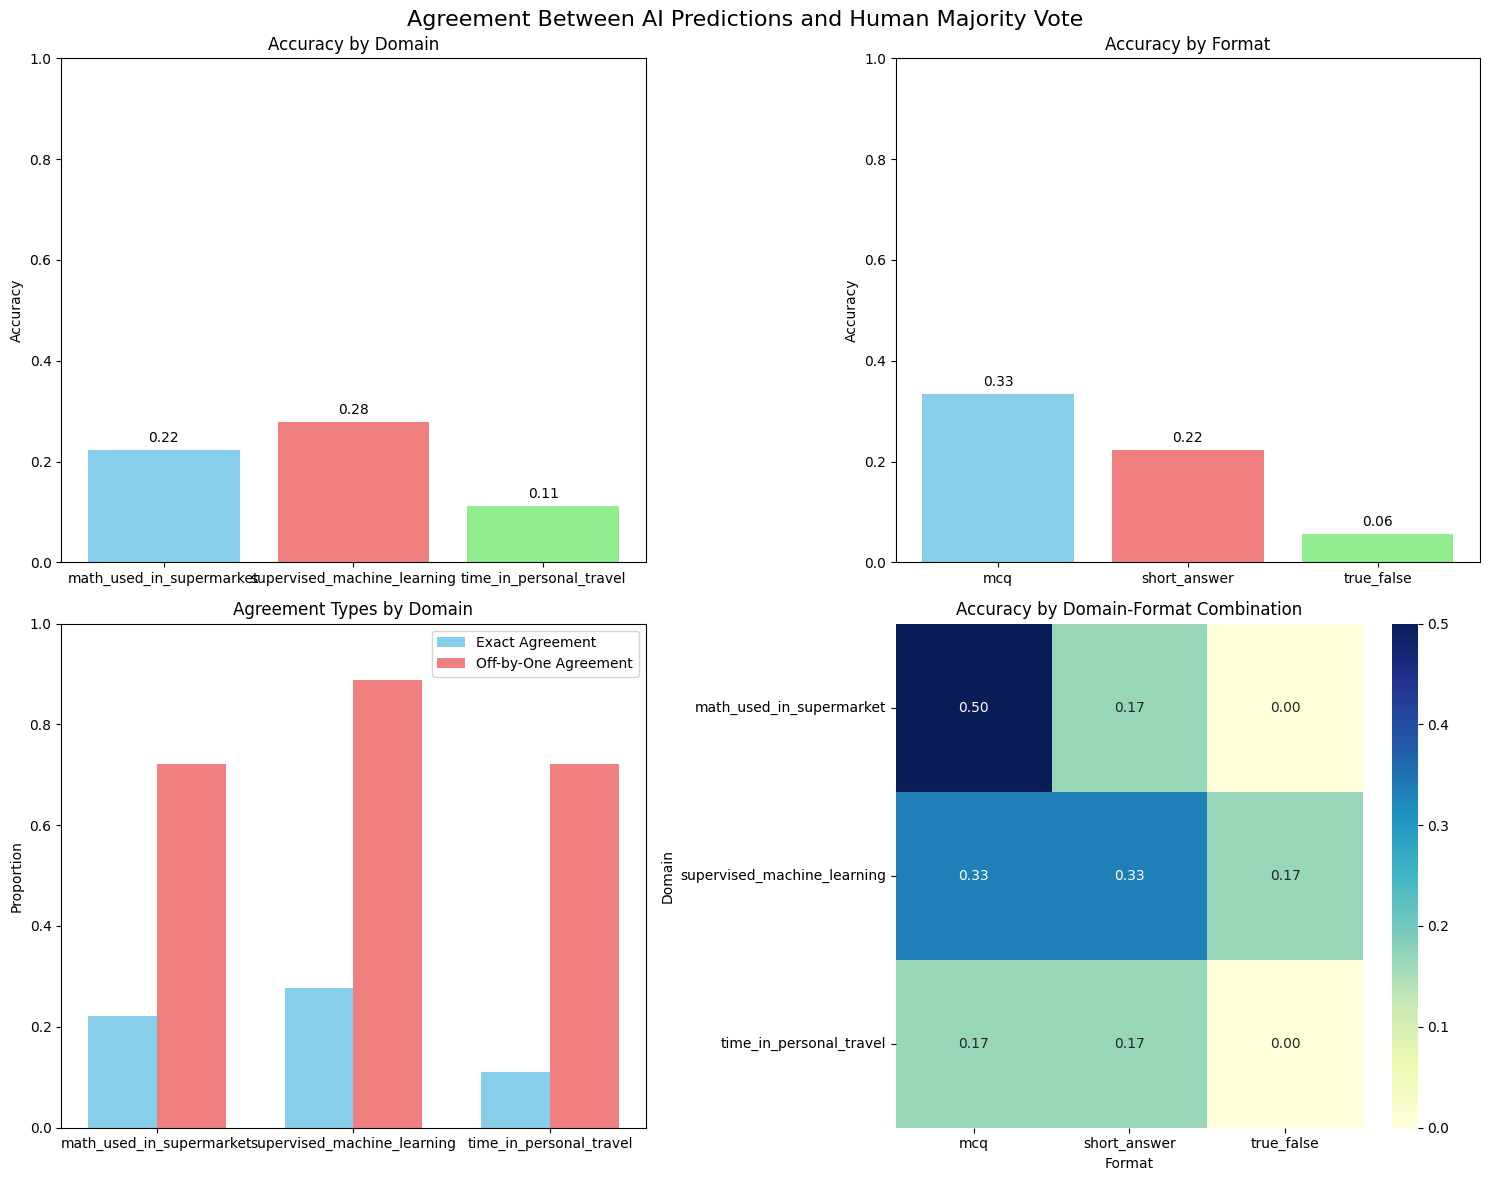

AGREEMENT BETWEEN AI PREDICTIONS AND HUMAN MAJORITY VOTE

Overall Agreement:
  Accuracy: 0.204
  Cohen's Kappa: 0.619
  Exact Agreement: 0.204
  Off-by-One Agreement: 0.778
  Number of Questions: 54

By Domain:
  math_used_in_supermarket:
    Accuracy: 0.222
    Cohen's Kappa: 0.615
    Exact Agreement: 0.222
    Off-by-One Agreement: 0.722
    Number of Questions: 18
  supervised_machine_learning:
    Accuracy: 0.278
    Cohen's Kappa: 0.640
    Exact Agreement: 0.278
    Off-by-One Agreement: 0.889
    Number of Questions: 18
  time_in_personal_travel:
    Accuracy: 0.111
    Cohen's Kappa: 0.612
    Exact Agreement: 0.111
    Off-by-One Agreement: 0.722
    Number of Questions: 18

By Format:
  mcq:
    Accuracy: 0.333
    Cohen's Kappa: 0.595
    Exact Agreement: 0.333
    Off-by-One Agreement: 0.778
    Number of Questions: 18
  short_answer:
    Accuracy: 0.222
    Cohen's Kappa: 0.676
    Exact Agreement: 0.222
    Off-by-One Agreement: 0.778
    Number of Questions: 18
  true_f

In [7]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, accuracy_score

# Load the data
df = pd.read_csv('z_human_evaluation.csv')

# Define human judge columns
human_judges = [f'categorisation_human_{i:04d}_num' for i in range(1, 8)]

# Function to calculate majority vote with tie-breaking (smallest category)
def calculate_majority_vote(row):
    # Get non-NaN human ratings
    ratings = [x for x in row[human_judges] if not pd.isna(x)]
    
    if len(ratings) == 0:
        return np.nan
    
    # Count frequencies
    counter = Counter(ratings)
    max_count = max(counter.values())
    
    # Find all categories with the maximum frequency
    modes = [k for k, v in counter.items() if v == max_count]
    
    # If there's a tie, return the smallest value
    if len(modes) > 1:
        return min(modes)
    else:
        return modes[0]

# Calculate majority vote for each question
df['human_majority'] = df.apply(calculate_majority_vote, axis=1)

# Remove rows where we couldn't calculate majority vote
df_clean = df.dropna(subset=['human_majority', 'ci_complexity_category_num'])

# Function to calculate agreement metrics
def calculate_agreement_metrics(ai_ratings, human_ratings):
    accuracy = accuracy_score(human_ratings, ai_ratings)
    kappa = cohen_kappa_score(human_ratings, ai_ratings, weights='quadratic')
    
    # Calculate exact agreement and off-by-one agreement
    exact_agreement = np.mean(np.array(ai_ratings) == np.array(human_ratings))
    off_by_one = np.mean(np.abs(np.array(ai_ratings) - np.array(human_ratings)) <= 1)
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'exact_agreement': exact_agreement,
        'off_by_one_agreement': off_by_one,
        'n_questions': len(ai_ratings)
    }

# Calculate overall agreement
overall_metrics = calculate_agreement_metrics(
    df_clean['ci_complexity_category_num'].values, 
    df_clean['human_majority'].values
)

# Calculate agreement by domain
domain_metrics = {}
for domain in df_clean['domain'].unique():
    domain_df = df_clean[df_clean['domain'] == domain]
    domain_metrics[domain] = calculate_agreement_metrics(
        domain_df['ci_complexity_category_num'].values, 
        domain_df['human_majority'].values
    )

# Calculate agreement by format
format_metrics = {}
for fmt in df_clean['question_format'].unique():
    fmt_df = df_clean[df_clean['question_format'] == fmt]
    format_metrics[fmt] = calculate_agreement_metrics(
        fmt_df['ci_complexity_category_num'].values, 
        fmt_df['human_majority'].values
    )

# Calculate agreement by domain-format combination
combo_metrics = {}
for domain in df_clean['domain'].unique():
    for fmt in df_clean['question_format'].unique():
        combo_df = df_clean[(df_clean['domain'] == domain) & (df_clean['question_format'] == fmt)]
        if len(combo_df) > 0:
            combo_key = f"{domain} - {fmt}"
            combo_metrics[combo_key] = calculate_agreement_metrics(
                combo_df['ci_complexity_category_num'].values, 
                combo_df['human_majority'].values
            )

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Agreement Between AI Predictions and Human Majority Vote', fontsize=16)

# 1. Accuracy by domain
domain_acc = [domain_metrics[d]['accuracy'] for d in domain_metrics]
domain_names = list(domain_metrics.keys())
bars = axes[0, 0].bar(domain_names, domain_acc, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 0].set_title('Accuracy by Domain')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom')

# 2. Accuracy by format
format_acc = [format_metrics[f]['accuracy'] for f in format_metrics]
format_names = list(format_metrics.keys())
bars = axes[0, 1].bar(format_names, format_acc, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 1].set_title('Accuracy by Format')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_ylim(0, 1)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom')

# 3. Agreement types by domain
domain_categories = list(domain_metrics.keys())
exact_agreement = [domain_metrics[d]['exact_agreement'] for d in domain_metrics]
off_by_one = [domain_metrics[d]['off_by_one_agreement'] for d in domain_metrics]

x = np.arange(len(domain_categories))
width = 0.35

axes[1, 0].bar(x - width/2, exact_agreement, width, label='Exact Agreement', color='skyblue')
axes[1, 0].bar(x + width/2, off_by_one, width, label='Off-by-One Agreement', color='lightcoral')
axes[1, 0].set_title('Agreement Types by Domain')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(domain_categories)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

# 4. Heatmap of accuracy by domain-format combination
combo_acc = {k: combo_metrics[k]['accuracy'] for k in combo_metrics}
combo_df = pd.DataFrame([(k.split(' - ')[0], k.split(' - ')[1], v) for k, v in combo_acc.items()],
                       columns=['Domain', 'Format', 'Accuracy'])
heatmap_data = combo_df.pivot(index='Domain', columns='Format', values='Accuracy')

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Accuracy by Domain-Format Combination')

plt.tight_layout()
plt.show()

# Print detailed results
print("="*60)
print("AGREEMENT BETWEEN AI PREDICTIONS AND HUMAN MAJORITY VOTE")
print("="*60)

print(f"\nOverall Agreement:")
print(f"  Accuracy: {overall_metrics['accuracy']:.3f}")
print(f"  Cohen's Kappa: {overall_metrics['kappa']:.3f}")
print(f"  Exact Agreement: {overall_metrics['exact_agreement']:.3f}")
print(f"  Off-by-One Agreement: {overall_metrics['off_by_one_agreement']:.3f}")
print(f"  Number of Questions: {overall_metrics['n_questions']}")

print(f"\nBy Domain:")
for domain, metrics in domain_metrics.items():
    print(f"  {domain}:")
    print(f"    Accuracy: {metrics['accuracy']:.3f}")
    print(f"    Cohen's Kappa: {metrics['kappa']:.3f}")
    print(f"    Exact Agreement: {metrics['exact_agreement']:.3f}")
    print(f"    Off-by-One Agreement: {metrics['off_by_one_agreement']:.3f}")
    print(f"    Number of Questions: {metrics['n_questions']}")

print(f"\nBy Format:")
for fmt, metrics in format_metrics.items():
    print(f"  {fmt}:")
    print(f"    Accuracy: {metrics['accuracy']:.3f}")
    print(f"    Cohen's Kappa: {metrics['kappa']:.3f}")
    print(f"    Exact Agreement: {metrics['exact_agreement']:.3f}")
    print(f"    Off-by-One Agreement: {metrics['off_by_one_agreement']:.3f}")
    print(f"    Number of Questions: {metrics['n_questions']}")

print(f"\nBy Domain-Format Combination:")
for combo, metrics in combo_metrics.items():
    print(f"  {combo}:")
    print(f"    Accuracy: {metrics['accuracy']:.3f}")
    print(f"    Cohen's Kappa: {metrics['kappa']:.3f}")
    print(f"    Number of Questions: {metrics['n_questions']}")